In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15, 'lines.linewidth': 2,
    'xtick.labelsize': 13, 'ytick.labelsize': 13,
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 1200,
})

import yaml
import numpy as np

from irc.manager import IRCManager
from boxforage.utils import plot_single_box_episode

# Train one agent for a single box environment

In [2]:
manager = IRCManager(defaults='irc_defaults/single_box.yaml')

## Train an agent
We train a rational agent for the assume environment parameter $p_\mathrm{appear}=0.2, p_\mathrm{cue}=0.8, r_\mathrm{food}=10$.

The following can also be done by running `demo-train.py` in command line:
```bash
python demo-train.py env_param=[0.2,0.8,10] num_epochs=30
```

Checkpoint (epoch 30) loaded.
Agent (seed 100) was trained for 30 epochs.


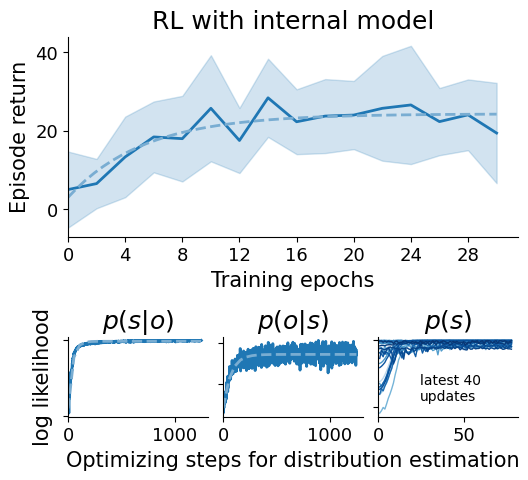

In [3]:
env_param = [0.2, 0.8, 10]
num_epochs = 30

seed = 100
agent = manager.train_agent(env_param, seed=seed, num_epochs=num_epochs)
agent, fig = manager.inspect_agent(env_param, seed=seed)

## Run the agent in an environment
We create another environment which has the same observation space and action space as the assumed one, albeit with a different set of environment parameters $(0.3, 0.6, 10)$.

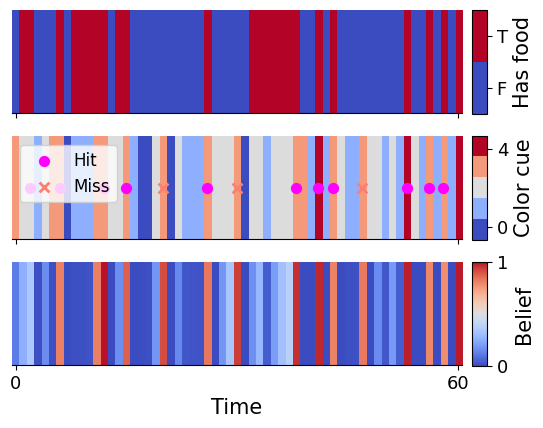

In [4]:
from boxforage.single_box import SingleBoxForaging

env = SingleBoxForaging(spec=manager.agent_manager.defaults.env.spec)
env.set_param([0.3, 0.6, 10.])

episode = agent.run_one_episode(env=env, num_steps=60)
fig = plot_single_box_episode(episode)

We can save the episode data in an external `pickle` file.

In [5]:
import os, pickle

episode_path = 'episode_00.pickle'

if os.path.exists(f'store/{episode_path}'):
    print(f"File store/{episode_path} already exists, will not be overwritten.")
else:
    with open(f'store/{episode_path}', 'wb') as f:
        pickle.dump({
            'external_env_param': env.get_param(),
            'internal_env_param': agent.model.env.get_param(),
            **episode,
        }, f)
    print(f"Episode data saved at '{episode_path}'.")

File store/episode_00.pickle already exists, will not be overwritten.


# Train multiple agents for different environments

## Sweep over parameter grid

We define a grid of environment parameters, and train multiple agents for each of the combination using different random seeds.

The following can also be done by running `demo-sweep.py` in command line:
```bash
python demo-sweep.py env_param_grid=param_grids/single_box.yaml num_epochs=10 count=5
```

In [6]:
env_param_grid = [
    [0.05, 0.15, 0.2, 0.25], # p_appear
    [0.2, 0.4, 0.6, 0.8], # p_cue
    [2., 10.], # r_food
]
agent_seeds = list(range(10))

num_epochs = 10 # number of RL epochs
count = 5 # number of agents to be trained

manager.train_agents(env_param_grid=env_param_grid, seeds=agent_seeds, num_epochs=num_epochs, count=count)

0 works processed.
All works are processed or being processed.


In [7]:
report = manager.overview_agents(env_param_grid=env_param_grid, seeds=agent_seeds)

Average number of trained epochs: 30.0
Approximate training time 33m09.90s per epoch.
Approximate evaluation time 3m51.42s.
Average training optimality 99.4%


# Compute likelihood of an episode

## Likelihood of a specific agent

Given a sequence actions and observations, we compute the likelihood of episode data conditioned on the agent that generates it.

In [8]:
logp = agent.episode_likelihood(episode['actions'], episode['observations'])
print('log likelihood {:.3f}'.format(logp))

log likelihood -9.787


## Likelihood of a series of agents

After multiple agents have been trained on a grid of environment parameters, compute the likelihood of episode data conditioned on each agent.

In [9]:
from irc.utils import logmeanexp

episode_path = 'episode_00.pickle'

logps = manager.compute_logps(
    episode_path=episode_path, env_param_grid=env_param_grid,
    agent_seeds=agent_seeds, min_epoch=20, min_optimality=0.99,
)

Use default belief seeds [0, 1, 2, 3, 4, 5, 6, 7] for each run.
298 valid agents found.
Computing likelihood of episode A2A710...
0 works processed.
All works are processed or being processed.
93.01% of the likelihood entries have been computed.


In [10]:
logps = logmeanexp(logps, axis=(-2, -1))
print(f"Log likelihood of all environments saved in an array of shape {logps.shape}")

Log likelihood of all environments saved in an array of shape (4, 4, 2)
